In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 5
2023-07-30 06:57:01.351066


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-14.3435)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(4.5727)
penalty_target_min tensor(-11.7090) penalty_target_max tensor(4.5254)
train_loss:  -8.921233970642088
valid_loss:  -8.2177935546875
h_min_tilde -11.708967 ell_tilde -8.780545887451172 kappa_tilde 0.0005843636860854795


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.430511474609375e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.646362543106079

 2 3.4087841510772705

 3 3.5712008476257324

 4 3.3365261554718018

 5 3.05735445022583

 6 3.2930901050567627

 7 3.260887861251831

 8 3.40950345993042

 9 3.2681565284729004

 10 3.2403957843780518

 11 3.304750919342041

 12 3.2037768363952637

 13 3.29203462600708

 14 3.2715678215026855

 15 3.5589373111724854

 16 3.220489501953125

 17 3.283574342727661

 18 3.2197906970977783

 19 3.2716686725616455

 20 3.3121519088745117

 21 3.2715108394622803

 22 3.1633594036102295

 23 3.7569708824157715

 24 3.405348062515259

 25 3.3512983322143555

 26 3.031303644180298

 27 3.333416700363159

 28 3.5650248527526855

 29 3.314979076385498

 30 3.508329391479492

 31 3.2393178939819336

 32 3.441005229949951

 33 3.035269021987915

 34 3.32147216796875

 35 3.4252028465270996

 36 3.353872776031494

 37 4.324790000915527

 38 6.908743619918823

 39 6.983196496963501

 40 4.316492795944214

 41 3.365668773651123

 42 3.3662612438201904

 43 3.6741414070129395

 4

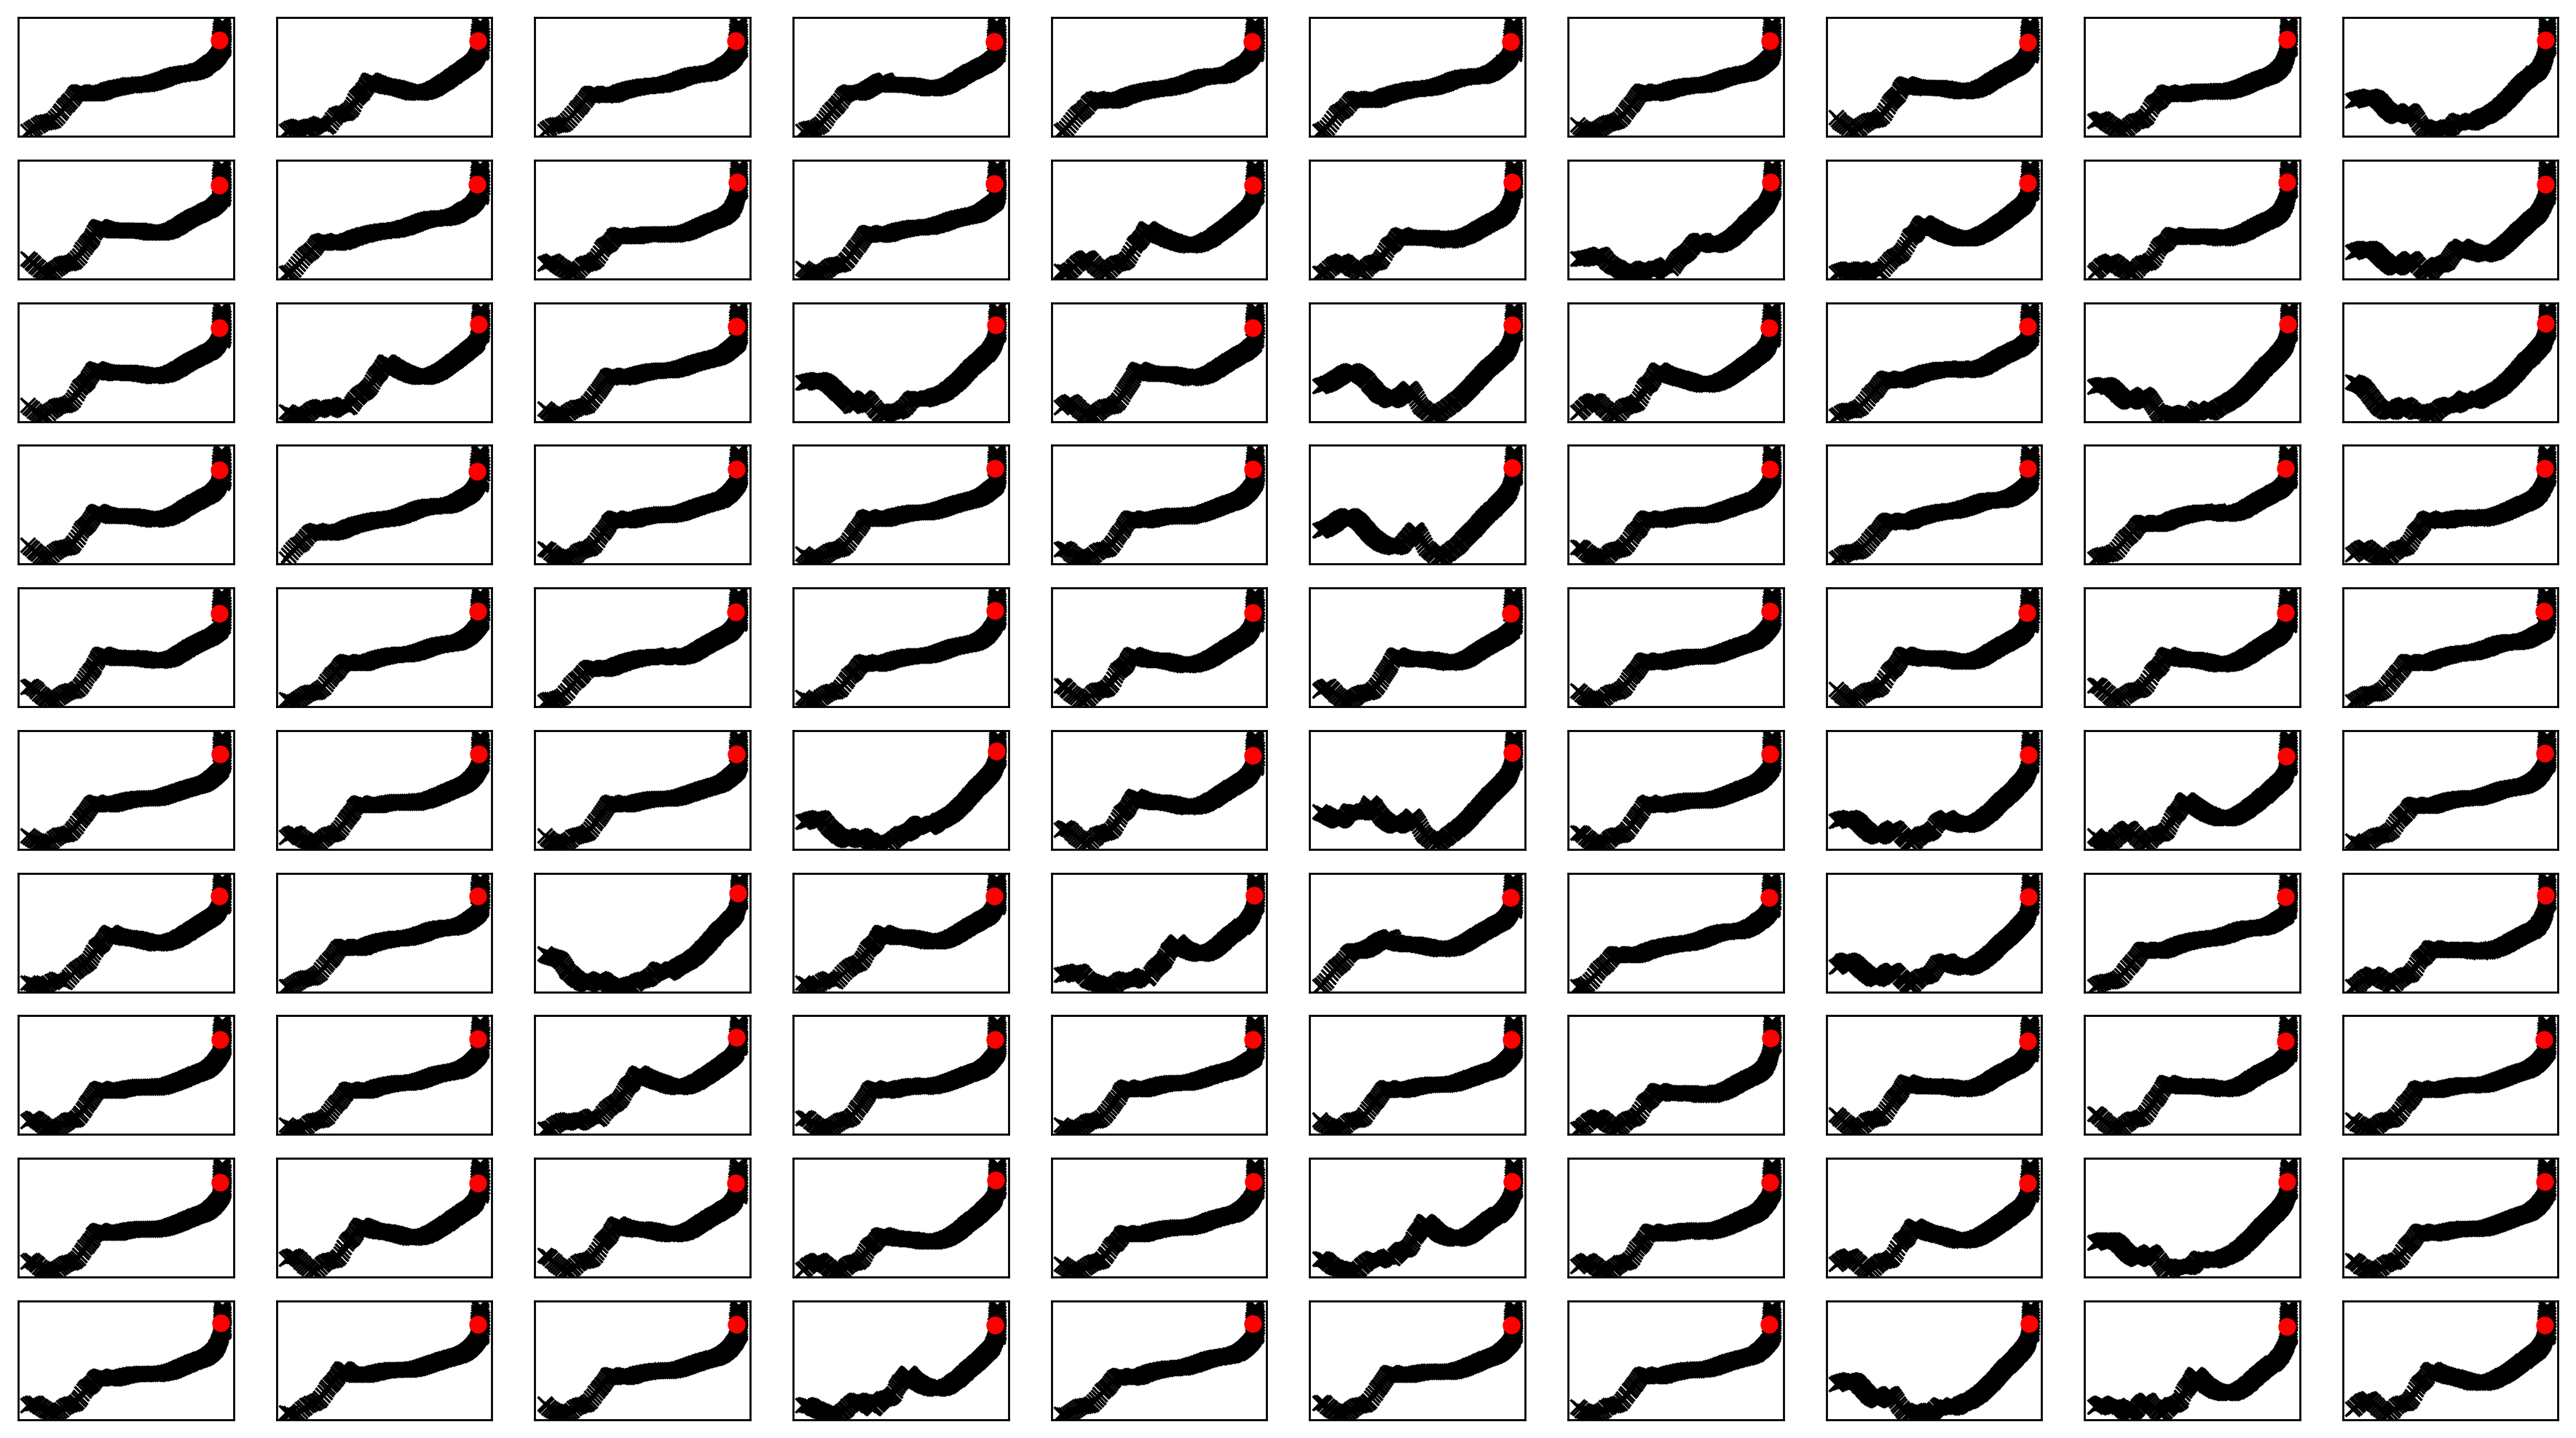

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

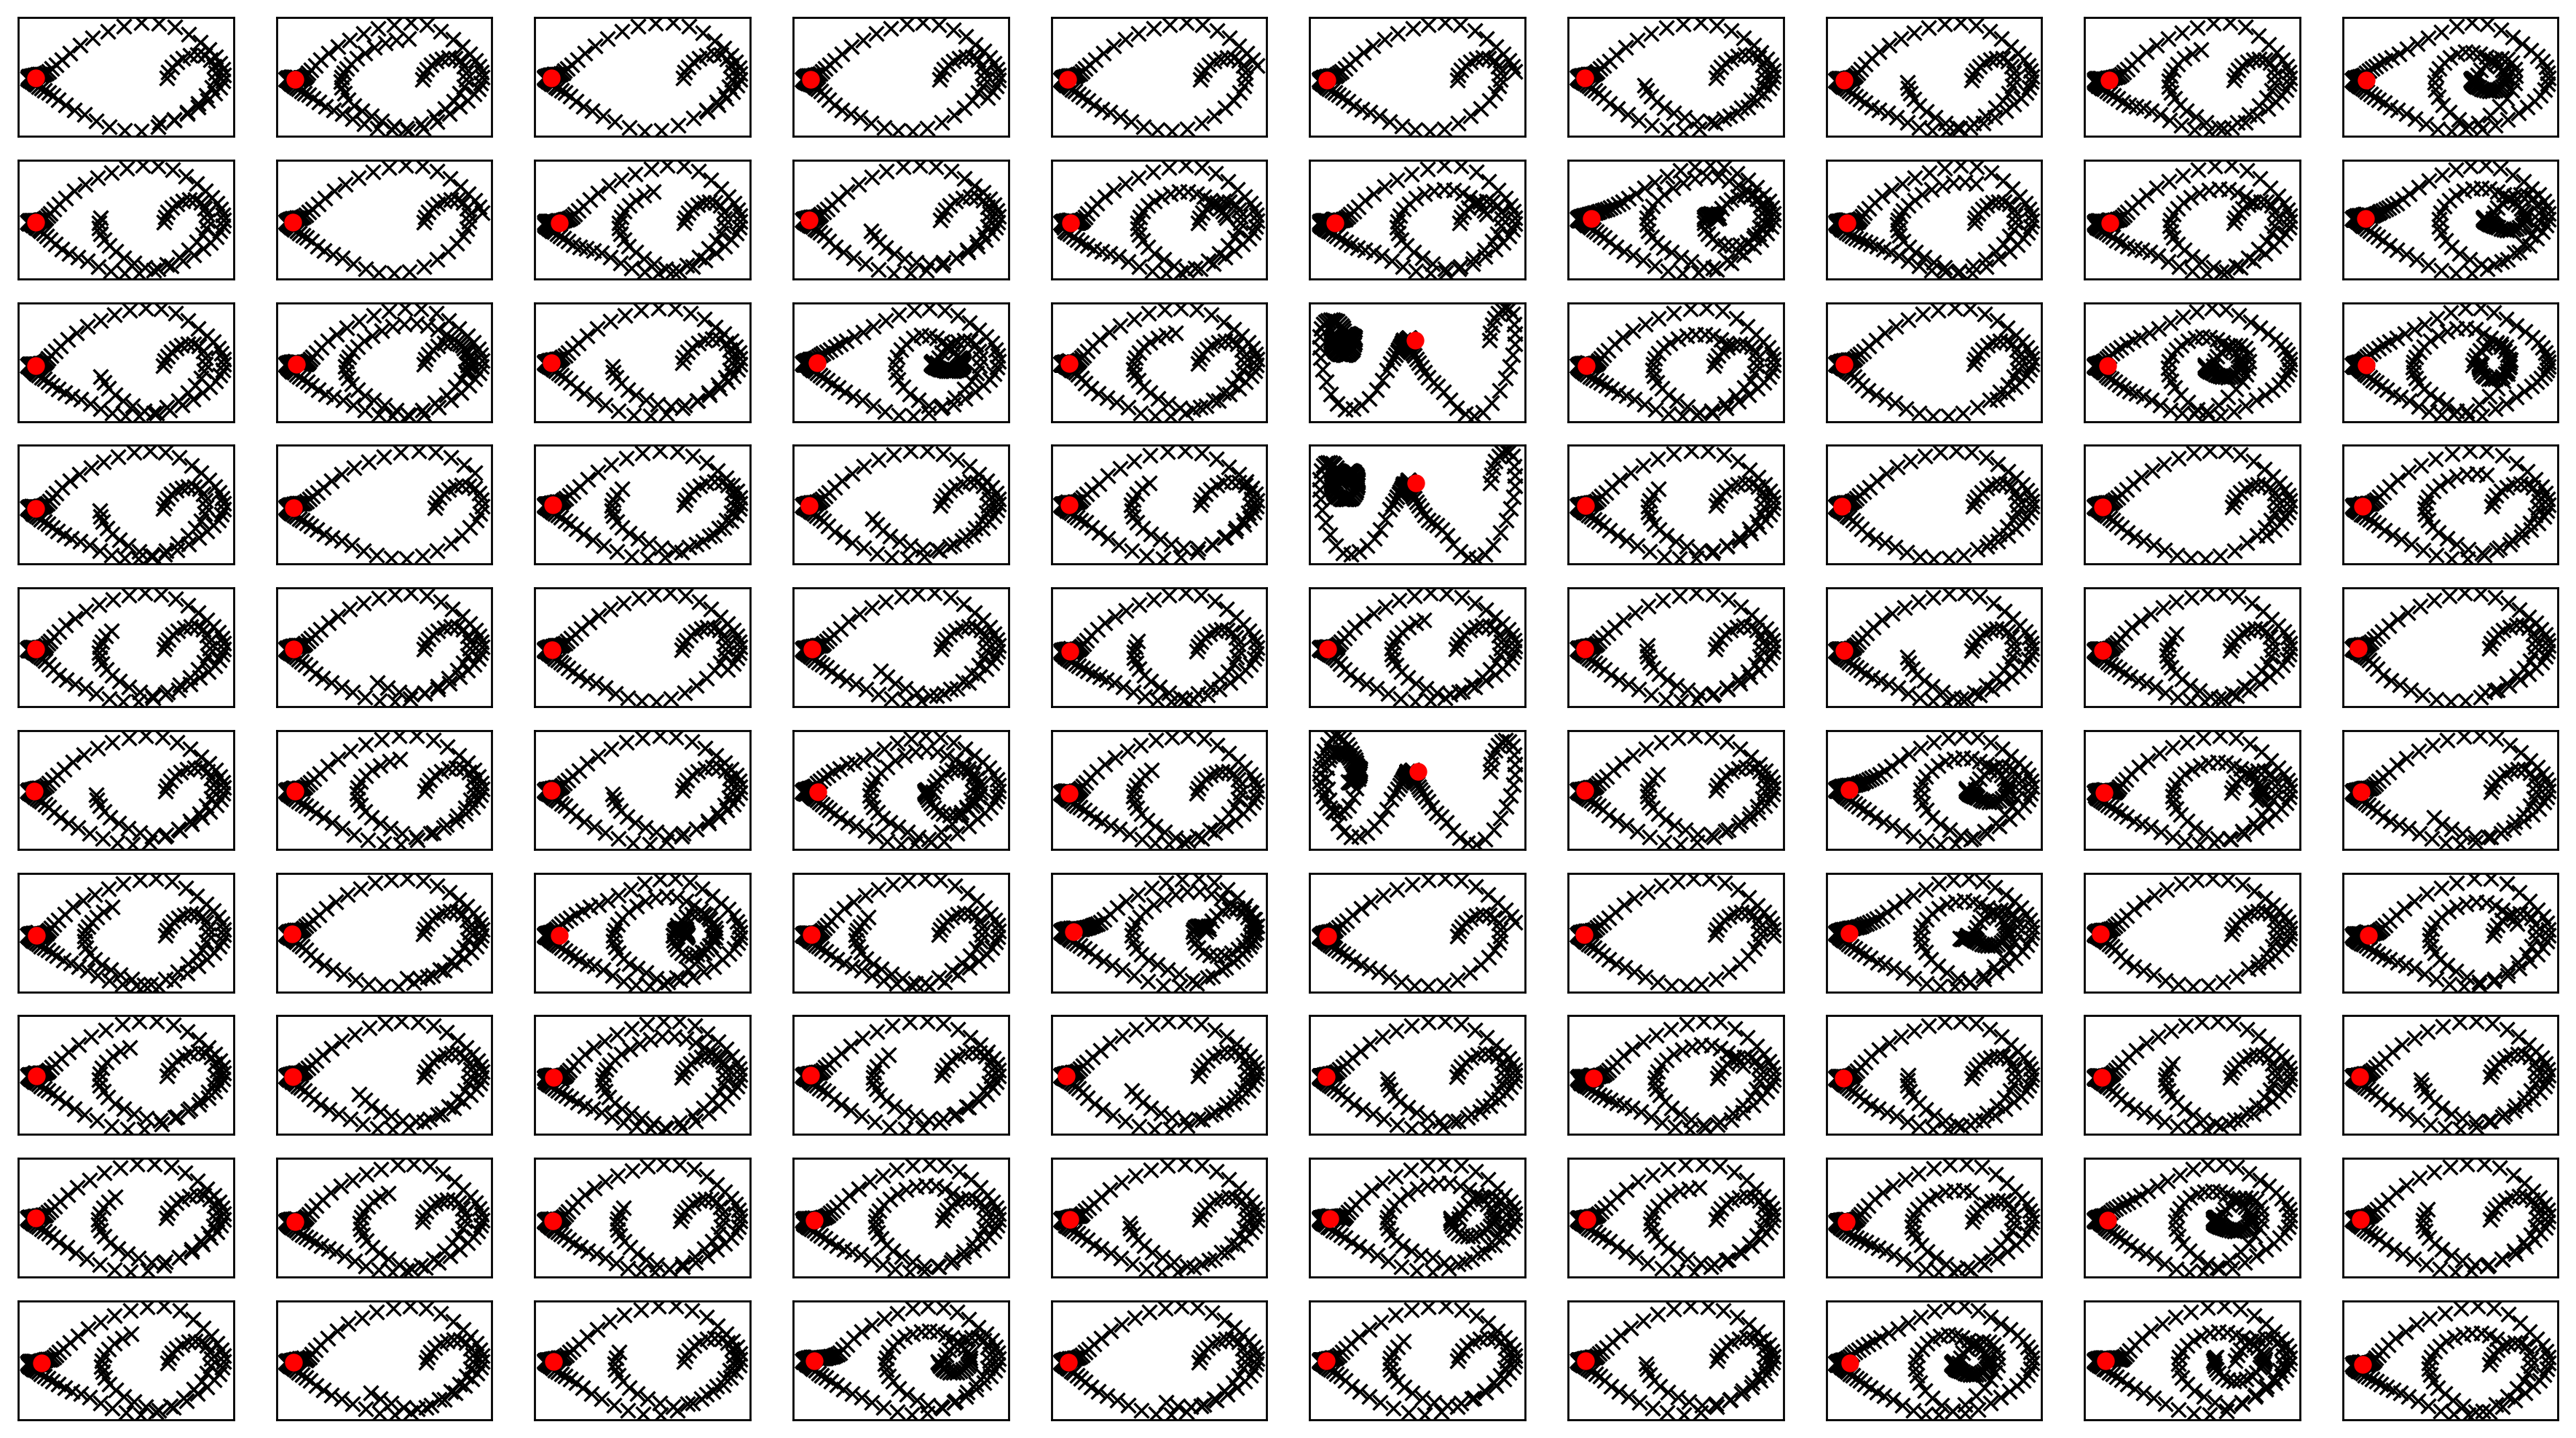

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-30 07:03:53.007625


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.32642  validloss 1.40441±0.00000  bestvalidloss 1.40441  last_update 0
train: iter 1  trainloss 1.19133  validloss 1.22913±0.00000  bestvalidloss 1.22913  last_update 0
train: iter 2  trainloss 1.08033  validloss 1.11775±0.00000  bestvalidloss 1.11775  last_update 0
train: iter 3  trainloss 0.97700  validloss 1.02055±0.00000  bestvalidloss 1.02055  last_update 0
train: iter 4  trainloss 0.90224  validloss 0.93819±0.00000  bestvalidloss 0.93819  last_update 0
train: iter 5  trainloss 0.84735  validloss 0.88355±0.00000  bestvalidloss 0.88355  last_update 0
train: iter 6  trainloss 0.79646  validloss 0.85506±0.00000  bestvalidloss 0.85506  last_update 0
train: iter 7  trainloss 0.74580  validloss 0.78559±0.00000  bestvalidloss 0.78559  last_update 0
train: iter 8  trainloss 0.69954  validloss 0.75795±0.00000  bestvalidloss 0.75795  last_update 0
train: iter 9  trainloss 0.66442  validloss 0.68755±0.00000  bestvalidloss 0.68755  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.36618  validloss 0.34126±0.00000  bestvalidloss 0.32037  last_update 7
train: iter 84  trainloss 0.36837  validloss 0.31570±0.00000  bestvalidloss 0.31570  last_update 0
train: iter 85  trainloss 0.36775  validloss 0.35222±0.00000  bestvalidloss 0.31570  last_update 1
train: iter 86  trainloss 0.36578  validloss 0.32296±0.00000  bestvalidloss 0.31570  last_update 2
train: iter 87  trainloss 0.36466  validloss 0.32782±0.00000  bestvalidloss 0.31570  last_update 3
train: iter 88  trainloss 0.36573  validloss 0.35451±0.00000  bestvalidloss 0.31570  last_update 4
train: iter 89  trainloss 0.36187  validloss 0.35418±0.00000  bestvalidloss 0.31570  last_update 5
train: iter 90  trainloss 0.37252  validloss 0.37228±0.00000  bestvalidloss 0.31570  last_update 6
train: iter 91  trainloss 0.35800  validloss 0.33548±0.00000  bestvalidloss 0.31570  last_update 7
train: iter 92  trainloss 0.35994  validloss 0.33213±0.00000  bestvalidloss 0.31570  last_update 8
train: ite

train: iter 165  trainloss 0.32757  validloss 0.31945±0.00000  bestvalidloss 0.28616  last_update 13
train: iter 166  trainloss 0.32329  validloss 0.30242±0.00000  bestvalidloss 0.28616  last_update 14
train: iter 167  trainloss 0.32564  validloss 0.29360±0.00000  bestvalidloss 0.28616  last_update 15
train: iter 168  trainloss 0.32722  validloss 0.34905±0.00000  bestvalidloss 0.28616  last_update 16
train: iter 169  trainloss 0.32488  validloss 0.30176±0.00000  bestvalidloss 0.28616  last_update 17
train: iter 170  trainloss 0.33102  validloss 0.29381±0.00000  bestvalidloss 0.28616  last_update 18
train: iter 171  trainloss 0.32141  validloss 0.30482±0.00000  bestvalidloss 0.28616  last_update 19
train: iter 172  trainloss 0.32344  validloss 0.28817±0.00000  bestvalidloss 0.28616  last_update 20
train: iter 173  trainloss 0.32884  validloss 0.29729±0.00000  bestvalidloss 0.28616  last_update 21
train: iter 174  trainloss 0.32629  validloss 0.33735±0.00000  bestvalidloss 0.28616  last_

train: iter 247  trainloss 0.30738  validloss 0.29009±0.00000  bestvalidloss 0.26992  last_update 7
train: iter 248  trainloss 0.30714  validloss 0.29016±0.00000  bestvalidloss 0.26992  last_update 8
train: iter 249  trainloss 0.30586  validloss 0.31199±0.00000  bestvalidloss 0.26992  last_update 9
train: iter 250  trainloss 0.30040  validloss 0.29335±0.00000  bestvalidloss 0.26992  last_update 10
train: iter 251  trainloss 0.30338  validloss 0.29711±0.00000  bestvalidloss 0.26992  last_update 11
train: iter 252  trainloss 0.31050  validloss 0.27576±0.00000  bestvalidloss 0.26992  last_update 12
train: iter 253  trainloss 0.31178  validloss 0.29382±0.00000  bestvalidloss 0.26992  last_update 13
train: iter 254  trainloss 0.30719  validloss 0.29463±0.00000  bestvalidloss 0.26992  last_update 14
train: iter 255  trainloss 0.30519  validloss 0.28059±0.00000  bestvalidloss 0.26992  last_update 15
train: iter 256  trainloss 0.30308  validloss 0.28575±0.00000  bestvalidloss 0.26992  last_upd

train: iter 330  trainloss 0.29961  validloss 0.27406±0.00000  bestvalidloss 0.26373  last_update 15
train: iter 331  trainloss 0.29238  validloss 0.29253±0.00000  bestvalidloss 0.26373  last_update 16
train: iter 332  trainloss 0.29355  validloss 0.28950±0.00000  bestvalidloss 0.26373  last_update 17
train: iter 333  trainloss 0.29135  validloss 0.29937±0.00000  bestvalidloss 0.26373  last_update 18
train: iter 334  trainloss 0.29259  validloss 0.28532±0.00000  bestvalidloss 0.26373  last_update 19
train: iter 335  trainloss 0.29012  validloss 0.27821±0.00000  bestvalidloss 0.26373  last_update 20
train: iter 336  trainloss 0.29211  validloss 0.28023±0.00000  bestvalidloss 0.26373  last_update 21
train: iter 337  trainloss 0.29006  validloss 0.29461±0.00000  bestvalidloss 0.26373  last_update 22
train: iter 338  trainloss 0.29074  validloss 0.26349±0.00000  bestvalidloss 0.26349  last_update 0
train: iter 339  trainloss 0.29116  validloss 0.28198±0.00000  bestvalidloss 0.26349  last_u

train: iter 412  trainloss 0.27707  validloss 0.29033±0.00000  bestvalidloss 0.26034  last_update 2
train: iter 413  trainloss 0.28033  validloss 0.28151±0.00000  bestvalidloss 0.26034  last_update 3
train: iter 414  trainloss 0.28056  validloss 0.27594±0.00000  bestvalidloss 0.26034  last_update 4
train: iter 415  trainloss 0.27874  validloss 0.27276±0.00000  bestvalidloss 0.26034  last_update 5
train: iter 416  trainloss 0.27931  validloss 0.27493±0.00000  bestvalidloss 0.26034  last_update 6
train: iter 417  trainloss 0.28249  validloss 0.27094±0.00000  bestvalidloss 0.26034  last_update 7
train: iter 418  trainloss 0.27709  validloss 0.27976±0.00000  bestvalidloss 0.26034  last_update 8
train: iter 419  trainloss 0.28335  validloss 0.28892±0.00000  bestvalidloss 0.26034  last_update 9
train: iter 420  trainloss 0.28158  validloss 0.30389±0.00000  bestvalidloss 0.26034  last_update 10
train: iter 421  trainloss 0.28047  validloss 0.27581±0.00000  bestvalidloss 0.26034  last_update 1

train: iter 494  trainloss 0.27181  validloss 0.30151±0.00000  bestvalidloss 0.25577  last_update 6
train: iter 495  trainloss 0.27030  validloss 0.29210±0.00000  bestvalidloss 0.25577  last_update 7
train: iter 496  trainloss 0.26880  validloss 0.28750±0.00000  bestvalidloss 0.25577  last_update 8
train: iter 497  trainloss 0.26915  validloss 0.29062±0.00000  bestvalidloss 0.25577  last_update 9
train: iter 498  trainloss 0.27028  validloss 0.26977±0.00000  bestvalidloss 0.25577  last_update 10
train: iter 499  trainloss 0.26757  validloss 0.27495±0.00000  bestvalidloss 0.25577  last_update 11
train: iter 500  trainloss 0.27272  validloss 0.28618±0.00000  bestvalidloss 0.25577  last_update 12
train: iter 501  trainloss 0.26946  validloss 0.31362±0.00000  bestvalidloss 0.25577  last_update 13
train: iter 502  trainloss 0.27002  validloss 0.26204±0.00000  bestvalidloss 0.25577  last_update 14
train: iter 503  trainloss 0.27066  validloss 0.28171±0.00000  bestvalidloss 0.25577  last_upda

train: iter 576  trainloss 0.26435  validloss 0.25888±0.00000  bestvalidloss 0.25256  last_update 25
train: iter 577  trainloss 0.25818  validloss 0.26149±0.00000  bestvalidloss 0.25256  last_update 26
train: iter 578  trainloss 0.25848  validloss 0.26540±0.00000  bestvalidloss 0.25256  last_update 27
train: iter 579  trainloss 0.26240  validloss 0.24837±0.00000  bestvalidloss 0.24837  last_update 0
train: iter 580  trainloss 0.25926  validloss 0.25817±0.00000  bestvalidloss 0.24837  last_update 1
train: iter 581  trainloss 0.26080  validloss 0.26852±0.00000  bestvalidloss 0.24837  last_update 2
train: iter 582  trainloss 0.25945  validloss 0.28802±0.00000  bestvalidloss 0.24837  last_update 3
train: iter 583  trainloss 0.26309  validloss 0.26612±0.00000  bestvalidloss 0.24837  last_update 4
train: iter 584  trainloss 0.26241  validloss 0.26982±0.00000  bestvalidloss 0.24837  last_update 5
train: iter 585  trainloss 0.25822  validloss 0.27464±0.00000  bestvalidloss 0.24837  last_update

train: iter 658  trainloss 0.24967  validloss 0.25193±0.00000  bestvalidloss 0.24827  last_update 19
train: iter 659  trainloss 0.25105  validloss 0.25352±0.00000  bestvalidloss 0.24827  last_update 20
train: iter 660  trainloss 0.24782  validloss 0.24955±0.00000  bestvalidloss 0.24827  last_update 21
train: iter 661  trainloss 0.25029  validloss 0.26466±0.00000  bestvalidloss 0.24827  last_update 22
train: iter 662  trainloss 0.25161  validloss 0.27081±0.00000  bestvalidloss 0.24827  last_update 23
train: iter 663  trainloss 0.24942  validloss 0.25989±0.00000  bestvalidloss 0.24827  last_update 24
train: iter 664  trainloss 0.25045  validloss 0.30213±0.00000  bestvalidloss 0.24827  last_update 25
train: iter 665  trainloss 0.24843  validloss 0.27873±0.00000  bestvalidloss 0.24827  last_update 26
train: iter 666  trainloss 0.25437  validloss 0.31772±0.00000  bestvalidloss 0.24827  last_update 27
train: iter 667  trainloss 0.25449  validloss 0.29886±0.00000  bestvalidloss 0.24827  last_

train_loss:  -4.75061431683302
valid_loss:  -5.6358511420488355
weight_alpha 1.0 h_min_tilde -11.708967 ell_tilde -4.927661681876183 kappa_tilde 0.0003840107163934267
train_loss:  -4.251271153926849
valid_loss:  -4.066935050582886
weight_alpha 0.1 h_min_tilde -11.708967 ell_tilde -4.2144039332580565 kappa_tilde 0.00036528079107126237


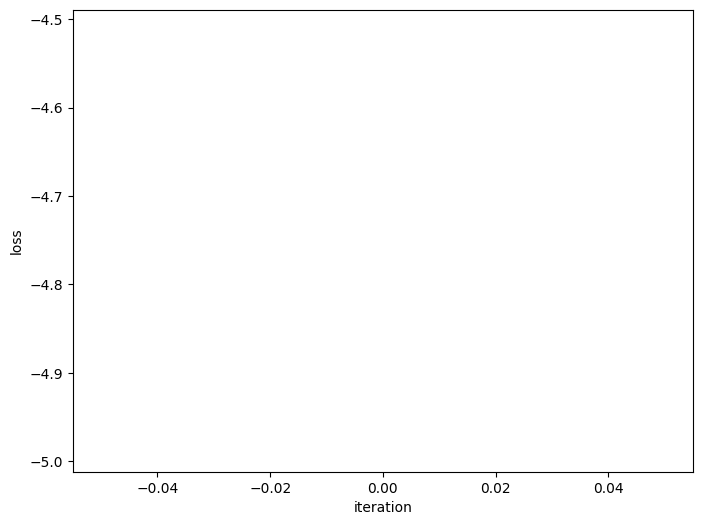

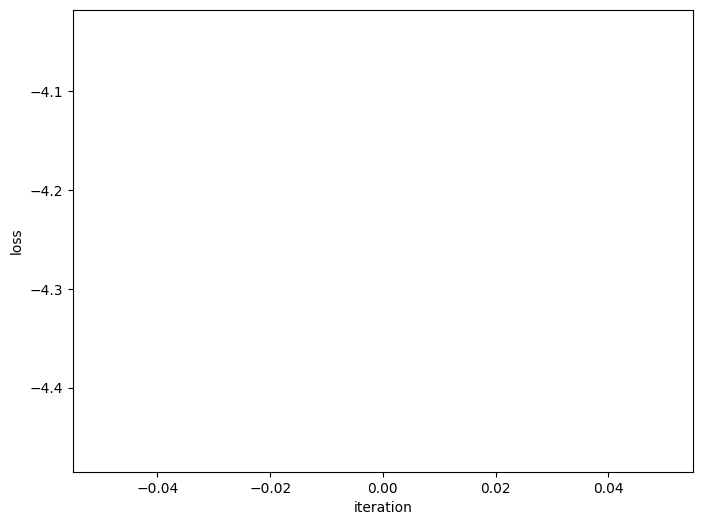

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -822.57384  validloss -813.65968±0.00000  bestvalidloss -813.65968  last_update 0
train: iter 1  trainloss -826.11292  validloss -810.07103±0.00000  bestvalidloss -813.65968  last_update 1
train: iter 2  trainloss -819.10527  validloss -686.97189±0.00000  bestvalidloss -813.65968  last_update 2
train: iter 3  trainloss -829.89555  validloss -782.56091±0.00000  bestvalidloss -813.65968  last_update 3
train: iter 4  trainloss -831.54242  validloss -792.61858±0.00000  bestvalidloss -813.65968  last_update 4
train: iter 5  trainloss -834.95013  validloss -793.82599±0.00000  bestvalidloss -813.65968  last_update 5
train: iter 6  trainloss -839.63456  validloss -795.21493±0.00000  bestvalidloss -813.65968  last_update 6
train: iter 7  trainloss -843.60194  validloss -805.42043±0.00000  bestvalidloss -813.65968  last_update 7
train: iter 8  trainloss -829.27983  validloss -803.09528±0.00000  bestvalidloss -813.65968  last_u

train: iter 75  trainloss -818.71037  validloss -789.52833±0.00000  bestvalidloss -813.65968  last_update 75
train: iter 76  trainloss -834.50565  validloss -783.63003±0.00000  bestvalidloss -813.65968  last_update 76
train: iter 77  trainloss -821.16224  validloss -746.36728±0.00000  bestvalidloss -813.65968  last_update 77
train: iter 78  trainloss -826.16480  validloss -732.02647±0.00000  bestvalidloss -813.65968  last_update 78
train: iter 79  trainloss -832.51418  validloss -777.17457±0.00000  bestvalidloss -813.65968  last_update 79
train: iter 80  trainloss -833.29007  validloss -762.93843±0.00000  bestvalidloss -813.65968  last_update 80
train: iter 81  trainloss -831.22091  validloss -778.03780±0.00000  bestvalidloss -813.65968  last_update 81
train: iter 82  trainloss -814.21605  validloss -752.66908±0.00000  bestvalidloss -813.65968  last_update 82
train: iter 83  trainloss -832.78273  validloss -748.16738±0.00000  bestvalidloss -813.65968  last_update 83
train: iter 84  tra

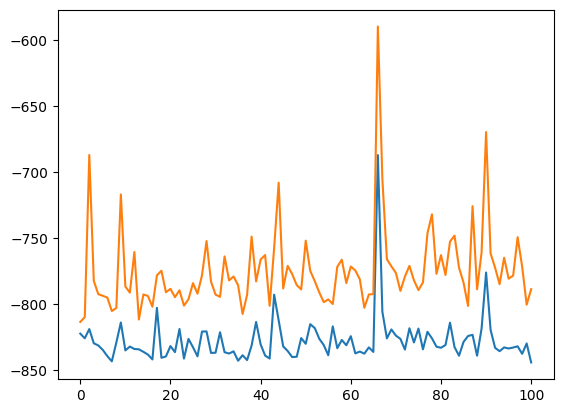

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-30 07:28:14.949285


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.29970  validloss 0.32049±0.00000  bestvalidloss 0.32049  last_update 0
train: iter 1  trainloss 0.28794  validloss 0.29696±0.00000  bestvalidloss 0.29696  last_update 0
train: iter 2  trainloss 0.28197  validloss 0.28400±0.00000  bestvalidloss 0.28400  last_update 0
train: iter 3  trainloss 0.28134  validloss 0.30053±0.00000  bestvalidloss 0.28400  last_update 1
train: iter 4  trainloss 0.27839  validloss 0.28159±0.00000  bestvalidloss 0.28159  last_update 0
train: iter 5  trainloss 0.27605  validloss 0.28099±0.00000  bestvalidloss 0.28099  last_update 0
train: iter 6  trainloss 0.27471  validloss 0.28542±0.00000  bestvalidloss 0.28099  last_update 1
train: iter 7  trainloss 0.27379  validloss 0.28121±0.00000  bestvalidloss 0.28099  last_update 2
train: iter 8  trainloss 0.27427  validloss 0.27659±0.00000  bestvalidloss 0.27659  last_update 0
train: iter 9  trainloss 0.27177  validloss 0.27594±0.00000  bestvalidloss 0.27594  last_update 0
train: iter 10  trai

train: iter 84  trainloss 0.25846  validloss 0.27545±0.00000  bestvalidloss 0.27251  last_update 62
train: iter 85  trainloss 0.25480  validloss 0.28099±0.00000  bestvalidloss 0.27251  last_update 63
train: iter 86  trainloss 0.25144  validloss 0.28106±0.00000  bestvalidloss 0.27251  last_update 64
train: iter 87  trainloss 0.25410  validloss 0.28290±0.00000  bestvalidloss 0.27251  last_update 65
train: iter 88  trainloss 0.25659  validloss 0.27761±0.00000  bestvalidloss 0.27251  last_update 66
train: iter 89  trainloss 0.25633  validloss 0.27892±0.00000  bestvalidloss 0.27251  last_update 67
train: iter 90  trainloss 0.25457  validloss 0.28197±0.00000  bestvalidloss 0.27251  last_update 68
train: iter 91  trainloss 0.25625  validloss 0.27773±0.00000  bestvalidloss 0.27251  last_update 69
train: iter 92  trainloss 0.25482  validloss 0.28113±0.00000  bestvalidloss 0.27251  last_update 70
train: iter 93  trainloss 0.25108  validloss 0.28525±0.00000  bestvalidloss 0.27251  last_update 71


train_loss:  -2.5445180332720283
valid_loss:  -3.247427806067467
weight_alpha 1.0 h_min_tilde -11.815712 ell_tilde -2.685099987831116 kappa_tilde 0.0003309406048112243
train_loss:  -3.9520424583435068
valid_loss:  -3.6663846549987795
weight_alpha 0.1 h_min_tilde -11.815712 ell_tilde -3.8949108976745612 kappa_tilde 0.0003553165582646679


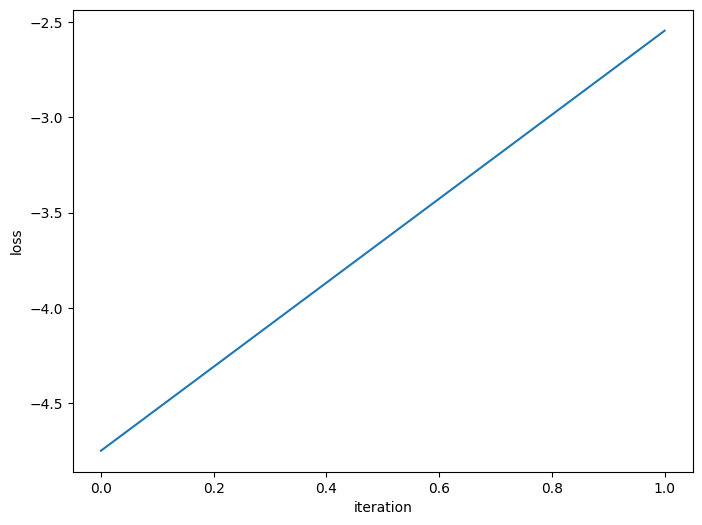

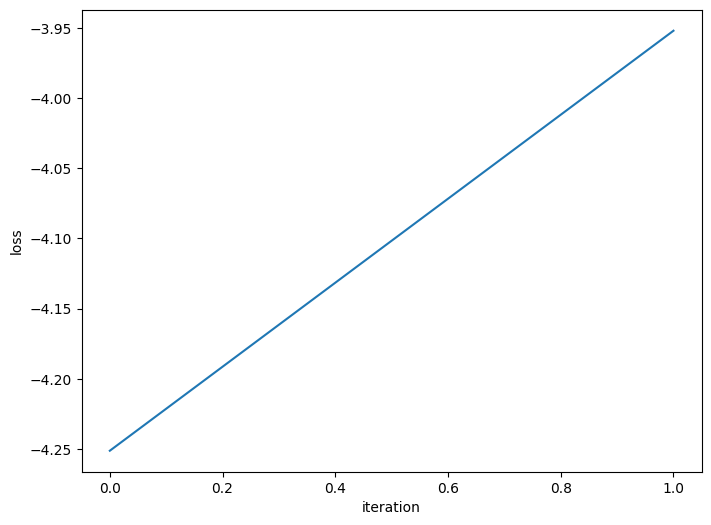

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -770.01887  validloss -735.02969±0.00000  bestvalidloss -735.02969  last_update 0
train: iter 1  trainloss -782.96594  validloss -743.01132±0.00000  bestvalidloss -743.01132  last_update 0
train: iter 2  trainloss -779.14982  validloss -741.91494±0.00000  bestvalidloss -743.01132  last_update 1
train: iter 3  trainloss -774.39191  validloss -725.82529±0.00000  bestvalidloss -743.01132  last_update 2
train: iter 4  trainloss -765.44800  validloss -704.83218±0.00000  bestvalidloss -743.01132  last_update 3
train: iter 5  trainloss -757.89325  validloss -720.92165±0.00000  bestvalidloss -743.01132  last_update 4
train: iter 6  trainloss -774.82087  validloss -737.45789±0.00000  bestvalidloss -743.01132  last_update 5
train: iter 7  trainloss -786.58144  validloss -738.80581±0.00000  bestvalidloss -743.01132  last_update 6
train: iter 8  trainloss -781.01031  validloss -728.75053±0.00000  bestvalidloss -743.01132  last_u

train: iter 76  trainloss -772.68234  validloss -704.57983±0.00000  bestvalidloss -750.96405  last_update 28
train: iter 77  trainloss -776.46490  validloss -706.13166±0.00000  bestvalidloss -750.96405  last_update 29
train: iter 78  trainloss -775.05362  validloss -697.71759±0.00000  bestvalidloss -750.96405  last_update 30
train: iter 79  trainloss -781.21859  validloss -738.18681±0.00000  bestvalidloss -750.96405  last_update 31
train: iter 80  trainloss -771.65087  validloss -678.52628±0.00000  bestvalidloss -750.96405  last_update 32
train: iter 81  trainloss -776.12380  validloss -726.07406±0.00000  bestvalidloss -750.96405  last_update 33
train: iter 82  trainloss -783.50760  validloss -738.47299±0.00000  bestvalidloss -750.96405  last_update 34
train: iter 83  trainloss -766.40586  validloss -729.72895±0.00000  bestvalidloss -750.96405  last_update 35
train: iter 84  trainloss -771.35733  validloss -721.08263±0.00000  bestvalidloss -750.96405  last_update 36
train: iter 85  tra

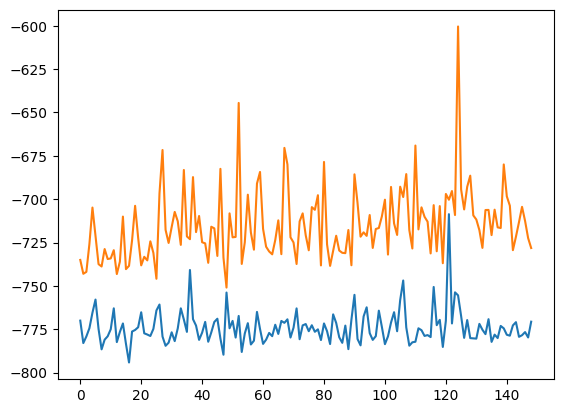

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-30 07:52:32.706119


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.29463  validloss 0.37372±0.00000  bestvalidloss 0.37372  last_update 0
train: iter 1  trainloss 0.28504  validloss 0.28686±0.00000  bestvalidloss 0.28686  last_update 0
train: iter 2  trainloss 0.28100  validloss 0.27787±0.00000  bestvalidloss 0.27787  last_update 0
train: iter 3  trainloss 0.28045  validloss 0.27426±0.00000  bestvalidloss 0.27426  last_update 0
train: iter 4  trainloss 0.27983  validloss 0.27035±0.00000  bestvalidloss 0.27035  last_update 0
train: iter 5  trainloss 0.28208  validloss 0.27056±0.00000  bestvalidloss 0.27035  last_update 1
train: iter 6  trainloss 0.27866  validloss 0.27304±0.00000  bestvalidloss 0.27035  last_update 2
train: iter 7  trainloss 0.28020  validloss 0.27468±0.00000  bestvalidloss 0.27035  last_update 3
train: iter 8  trainloss 0.27699  validloss 0.26932±0.00000  bestvalidloss 0.26932  last_update 0
train: iter 9  trainloss 0.27790  validloss 0.26520±0.00000  bestvalidloss 0.26520  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.26275  validloss 0.27084±0.00000  bestvalidloss 0.26435  last_update 2
train: iter 84  trainloss 0.26319  validloss 0.26539±0.00000  bestvalidloss 0.26435  last_update 3
train: iter 85  trainloss 0.26471  validloss 0.27358±0.00000  bestvalidloss 0.26435  last_update 4
train: iter 86  trainloss 0.26386  validloss 0.26751±0.00000  bestvalidloss 0.26435  last_update 5
train: iter 87  trainloss 0.26248  validloss 0.26561±0.00000  bestvalidloss 0.26435  last_update 6
train: iter 88  trainloss 0.26192  validloss 0.26597±0.00000  bestvalidloss 0.26435  last_update 7
train: iter 89  trainloss 0.26619  validloss 0.26486±0.00000  bestvalidloss 0.26435  last_update 8
train: iter 90  trainloss 0.26422  validloss 0.27601±0.00000  bestvalidloss 0.26435  last_update 9
train: iter 91  trainloss 0.26316  validloss 0.26567±0.00000  bestvalidloss 0.26435  last_update 10
train: iter 92  trainloss 0.26201  validloss 0.26681±0.00000  bestvalidloss 0.26435  last_update 11
train: i

train: iter 165  trainloss 0.25914  validloss 0.26751±0.00000  bestvalidloss 0.26188  last_update 22
train: iter 166  trainloss 0.25483  validloss 0.26539±0.00000  bestvalidloss 0.26188  last_update 23
train: iter 167  trainloss 0.25429  validloss 0.26768±0.00000  bestvalidloss 0.26188  last_update 24
train: iter 168  trainloss 0.25401  validloss 0.26321±0.00000  bestvalidloss 0.26188  last_update 25
train: iter 169  trainloss 0.25668  validloss 0.26916±0.00000  bestvalidloss 0.26188  last_update 26
train: iter 170  trainloss 0.25410  validloss 0.26522±0.00000  bestvalidloss 0.26188  last_update 27
train: iter 171  trainloss 0.25339  validloss 0.26768±0.00000  bestvalidloss 0.26188  last_update 28
train: iter 172  trainloss 0.25453  validloss 0.27174±0.00000  bestvalidloss 0.26188  last_update 29
train: iter 173  trainloss 0.25082  validloss 0.26870±0.00000  bestvalidloss 0.26188  last_update 30
train: iter 174  trainloss 0.25667  validloss 0.27515±0.00000  bestvalidloss 0.26188  last_

train: iter 248  trainloss 0.24925  validloss 0.27127±0.00000  bestvalidloss 0.25963  last_update 54
train: iter 249  trainloss 0.24893  validloss 0.26119±0.00000  bestvalidloss 0.25963  last_update 55
train: iter 250  trainloss 0.25167  validloss 0.26757±0.00000  bestvalidloss 0.25963  last_update 56
train: iter 251  trainloss 0.25014  validloss 0.26805±0.00000  bestvalidloss 0.25963  last_update 57
train: iter 252  trainloss 0.25048  validloss 0.26654±0.00000  bestvalidloss 0.25963  last_update 58
train: iter 253  trainloss 0.25356  validloss 0.26594±0.00000  bestvalidloss 0.25963  last_update 59
train: iter 254  trainloss 0.25145  validloss 0.27632±0.00000  bestvalidloss 0.25963  last_update 60
train: iter 255  trainloss 0.24843  validloss 0.26248±0.00000  bestvalidloss 0.25963  last_update 61
train: iter 256  trainloss 0.25226  validloss 0.26438±0.00000  bestvalidloss 0.25963  last_update 62
train: iter 257  trainloss 0.24854  validloss 0.26410±0.00000  bestvalidloss 0.25963  last_

train_loss:  -3.4205155923008923
valid_loss:  -4.565607442259789
weight_alpha 1.0 h_min_tilde -11.640576 ell_tilde -3.6495339622926717 kappa_tilde 0.00035375149382965986
train_loss:  -3.8592876976013173
valid_loss:  -3.6104989662170413
weight_alpha 0.1 h_min_tilde -11.640576 ell_tilde -3.809529951324462 kappa_tilde 0.0003573469675891415


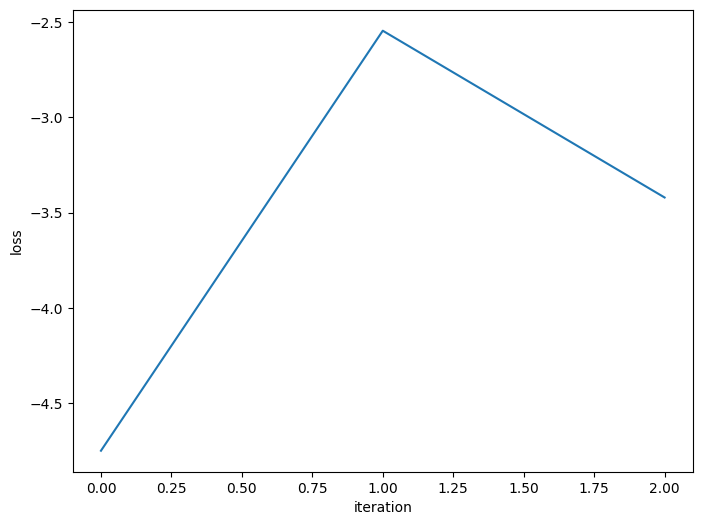

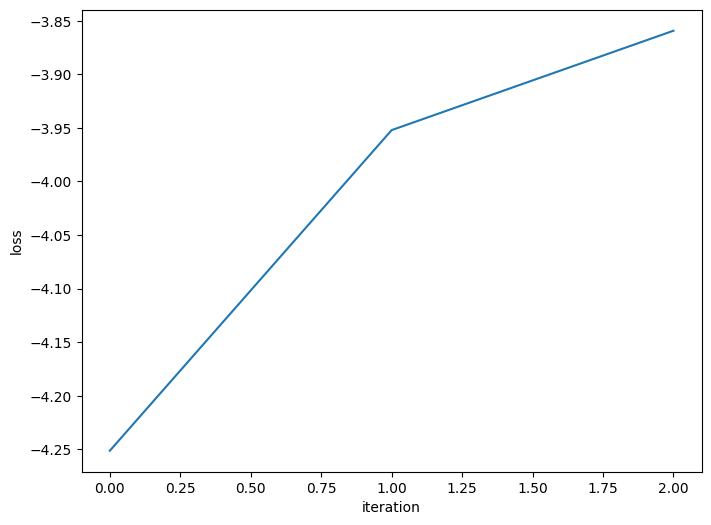

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -750.13105  validloss -718.83870±0.00000  bestvalidloss -718.83870  last_update 0
train: iter 1  trainloss -761.23882  validloss -686.54109±0.00000  bestvalidloss -718.83870  last_update 1
train: iter 2  trainloss -757.75676  validloss -686.64234±0.00000  bestvalidloss -718.83870  last_update 2
train: iter 3  trainloss -746.86942  validloss -712.54594±0.00000  bestvalidloss -718.83870  last_update 3
train: iter 4  trainloss -751.59923  validloss -706.25552±0.00000  bestvalidloss -718.83870  last_update 4
train: iter 5  trainloss -761.46138  validloss -704.22139±0.00000  bestvalidloss -718.83870  last_update 5
train: iter 6  trainloss -756.86278  validloss -678.14431±0.00000  bestvalidloss -718.83870  last_update 6
train: iter 7  trainloss -762.40582  validloss -699.75629±0.00000  bestvalidloss -718.83870  last_update 7
train: iter 8  trainloss -756.37235  validloss -709.24021±0.00000  bestvalidloss -718.83870  last_u

train: iter 76  trainloss -711.89554  validloss -561.19373±0.00000  bestvalidloss -718.87932  last_update 46
train: iter 77  trainloss -756.45871  validloss -637.13229±0.00000  bestvalidloss -718.87932  last_update 47
train: iter 78  trainloss -761.88605  validloss -687.32424±0.00000  bestvalidloss -718.87932  last_update 48
train: iter 79  trainloss -763.51796  validloss -682.49906±0.00000  bestvalidloss -718.87932  last_update 49
train: iter 80  trainloss -765.44986  validloss -688.61392±0.00000  bestvalidloss -718.87932  last_update 50
train: iter 81  trainloss -768.65302  validloss -699.88820±0.00000  bestvalidloss -718.87932  last_update 51
train: iter 82  trainloss -761.86910  validloss -702.96701±0.00000  bestvalidloss -718.87932  last_update 52
train: iter 83  trainloss -757.64505  validloss -698.29351±0.00000  bestvalidloss -718.87932  last_update 53
train: iter 84  trainloss -757.42852  validloss -691.53511±0.00000  bestvalidloss -718.87932  last_update 54
train: iter 85  tra

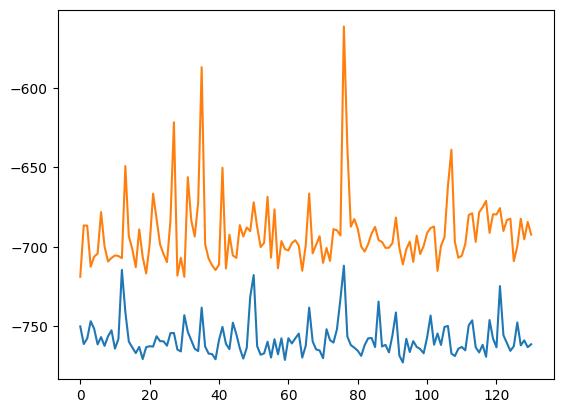

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-30 08:16:27.375628


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.32508  validloss 0.41996±0.00000  bestvalidloss 0.41996  last_update 0
train: iter 1  trainloss 0.30750  validloss 0.33793±0.00000  bestvalidloss 0.33793  last_update 0
train: iter 2  trainloss 0.29990  validloss 0.31758±0.00000  bestvalidloss 0.31758  last_update 0
train: iter 3  trainloss 0.30100  validloss 0.31523±0.00000  bestvalidloss 0.31523  last_update 0
train: iter 4  trainloss 0.29582  validloss 0.31724±0.00000  bestvalidloss 0.31523  last_update 1
train: iter 5  trainloss 0.29077  validloss 0.31000±0.00000  bestvalidloss 0.31000  last_update 0
train: iter 6  trainloss 0.29236  validloss 0.31817±0.00000  bestvalidloss 0.31000  last_update 1
train: iter 7  trainloss 0.29039  validloss 0.31173±0.00000  bestvalidloss 0.31000  last_update 2
train: iter 8  trainloss 0.29021  validloss 0.31964±0.00000  bestvalidloss 0.31000  last_update 3
train: iter 9  trainloss 0.29010  validloss 0.31639±0.00000  bestvalidloss 0.31000  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.27111  validloss 0.31817±0.00000  bestvalidloss 0.30008  last_update 23
train: iter 84  trainloss 0.27289  validloss 0.32682±0.00000  bestvalidloss 0.30008  last_update 24
train: iter 85  trainloss 0.27220  validloss 0.31738±0.00000  bestvalidloss 0.30008  last_update 25
train: iter 86  trainloss 0.27226  validloss 0.30398±0.00000  bestvalidloss 0.30008  last_update 26
train: iter 87  trainloss 0.27001  validloss 0.33437±0.00000  bestvalidloss 0.30008  last_update 27
train: iter 88  trainloss 0.26948  validloss 0.31911±0.00000  bestvalidloss 0.30008  last_update 28
train: iter 89  trainloss 0.27246  validloss 0.32959±0.00000  bestvalidloss 0.30008  last_update 29
train: iter 90  trainloss 0.26977  validloss 0.32290±0.00000  bestvalidloss 0.30008  last_update 30
train: iter 91  trainloss 0.26906  validloss 0.32206±0.00000  bestvalidloss 0.30008  last_update 31
train: iter 92  trainloss 0.27160  validloss 0.32776±0.00000  bestvalidloss 0.30008  last_update 32


train_loss:  -3.300674083000421
valid_loss:  -4.002465769934654
weight_alpha 1.0 h_min_tilde -11.753558 ell_tilde -3.4410324203872675 kappa_tilde 0.0003468434508340799
train_loss:  -4.249054348564147
valid_loss:  -3.7989826547622685
weight_alpha 0.1 h_min_tilde -11.753558 ell_tilde -4.159040009803772 kappa_tilde 0.0003628690166790314


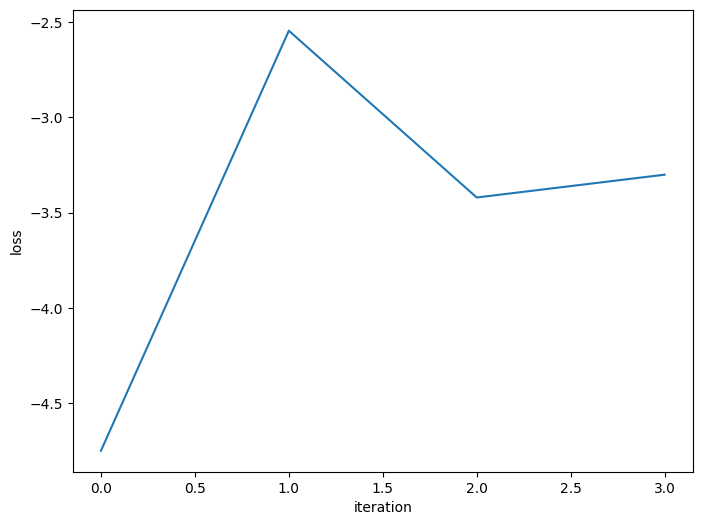

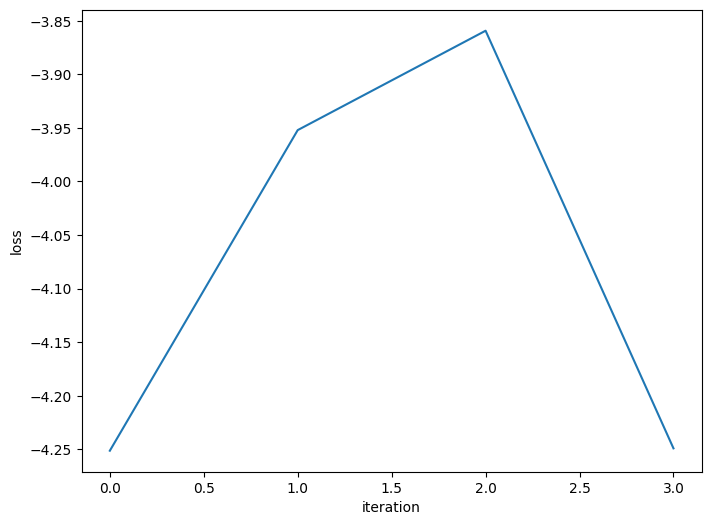

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -821.46784  validloss -753.24388±0.00000  bestvalidloss -753.24388  last_update 0
train: iter 1  trainloss -832.76968  validloss -760.50673±0.00000  bestvalidloss -760.50673  last_update 0
train: iter 2  trainloss -827.44924  validloss -742.51224±0.00000  bestvalidloss -760.50673  last_update 1
train: iter 3  trainloss -836.17381  validloss -745.41402±0.00000  bestvalidloss -760.50673  last_update 2
train: iter 4  trainloss -829.56606  validloss -775.37132±0.00000  bestvalidloss -775.37132  last_update 0
train: iter 5  trainloss -812.52510  validloss -712.34506±0.00000  bestvalidloss -775.37132  last_update 1
train: iter 6  trainloss -798.59139  validloss -675.79825±0.00000  bestvalidloss -775.37132  last_update 2
train: iter 7  trainloss -828.18042  validloss -753.49733±0.00000  bestvalidloss -775.37132  last_update 3
train: iter 8  trainloss -837.17165  validloss -750.49478±0.00000  bestvalidloss -775.37132  last_u

train: iter 76  trainloss -826.11450  validloss -744.61400±0.00000  bestvalidloss -775.55483  last_update 67
train: iter 77  trainloss -833.90382  validloss -770.54775±0.00000  bestvalidloss -775.55483  last_update 68
train: iter 78  trainloss -803.87814  validloss -758.46549±0.00000  bestvalidloss -775.55483  last_update 69
train: iter 79  trainloss -822.60478  validloss -755.24556±0.00000  bestvalidloss -775.55483  last_update 70
train: iter 80  trainloss -833.57241  validloss -764.77218±0.00000  bestvalidloss -775.55483  last_update 71
train: iter 81  trainloss -837.68020  validloss -750.05833±0.00000  bestvalidloss -775.55483  last_update 72
train: iter 82  trainloss -839.03853  validloss -751.13223±0.00000  bestvalidloss -775.55483  last_update 73
train: iter 83  trainloss -804.46288  validloss -742.69284±0.00000  bestvalidloss -775.55483  last_update 74
train: iter 84  trainloss -809.53292  validloss -758.45151±0.00000  bestvalidloss -775.55483  last_update 75
train: iter 85  tra

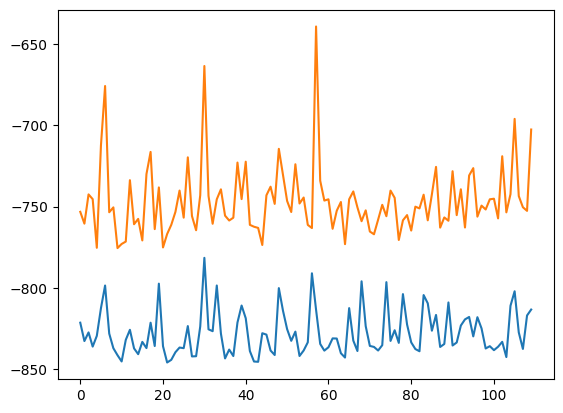

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-30 08:41:14.160977


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.31698  validloss 0.38238±0.00000  bestvalidloss 0.38238  last_update 0
train: iter 1  trainloss 0.30894  validloss 0.32955±0.00000  bestvalidloss 0.32955  last_update 0
train: iter 2  trainloss 0.30682  validloss 0.31244±0.00000  bestvalidloss 0.31244  last_update 0
train: iter 3  trainloss 0.30586  validloss 0.31914±0.00000  bestvalidloss 0.31244  last_update 1
train: iter 4  trainloss 0.30534  validloss 0.31479±0.00000  bestvalidloss 0.31244  last_update 2
train: iter 5  trainloss 0.30611  validloss 0.32386±0.00000  bestvalidloss 0.31244  last_update 3
train: iter 6  trainloss 0.30367  validloss 0.31664±0.00000  bestvalidloss 0.31244  last_update 4
train: iter 7  trainloss 0.29847  validloss 0.31710±0.00000  bestvalidloss 0.31244  last_update 5
train: iter 8  trainloss 0.29929  validloss 0.32501±0.00000  bestvalidloss 0.31244  last_update 6
train: iter 9  trainloss 0.30445  validloss 0.32226±0.00000  bestvalidloss 0.31244  last_update 7
train: iter 10  trai

train: iter 84  trainloss 0.28623  validloss 0.32155±0.00000  bestvalidloss 0.30456  last_update 67
train: iter 85  trainloss 0.28681  validloss 0.32849±0.00000  bestvalidloss 0.30456  last_update 68
train: iter 86  trainloss 0.28708  validloss 0.30853±0.00000  bestvalidloss 0.30456  last_update 69
train: iter 87  trainloss 0.28775  validloss 0.32251±0.00000  bestvalidloss 0.30456  last_update 70
train: iter 88  trainloss 0.28461  validloss 0.31714±0.00000  bestvalidloss 0.30456  last_update 71
train: iter 89  trainloss 0.28480  validloss 0.31410±0.00000  bestvalidloss 0.30456  last_update 72
train: iter 90  trainloss 0.28594  validloss 0.31204±0.00000  bestvalidloss 0.30456  last_update 73
train: iter 91  trainloss 0.28639  validloss 0.30754±0.00000  bestvalidloss 0.30456  last_update 74
train: iter 92  trainloss 0.28540  validloss 0.32213±0.00000  bestvalidloss 0.30456  last_update 75
train: iter 93  trainloss 0.28622  validloss 0.32130±0.00000  bestvalidloss 0.30456  last_update 76


train_loss:  -3.763618155074119
valid_loss:  -4.792115675091743
weight_alpha 1.0 h_min_tilde -11.764507 ell_tilde -3.9693176590776442 kappa_tilde 0.0003581678975435643
train_loss:  -4.131413281679154
valid_loss:  -3.6879461466312407
weight_alpha 0.1 h_min_tilde -11.764507 ell_tilde -4.0427198546695715 kappa_tilde 0.00035986621723352514


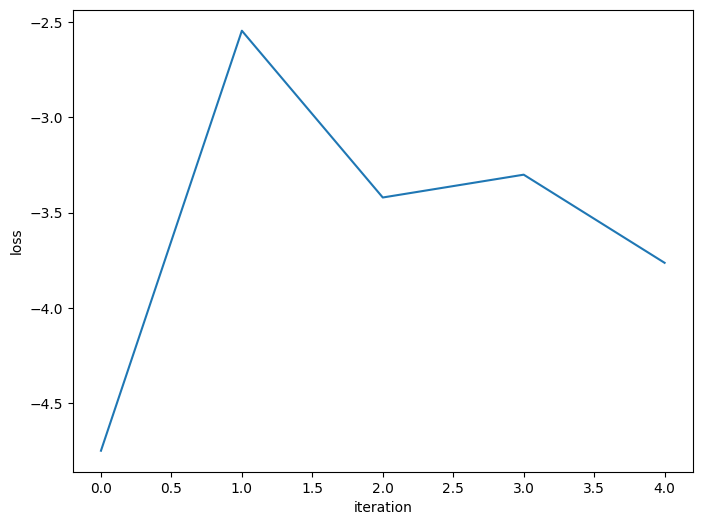

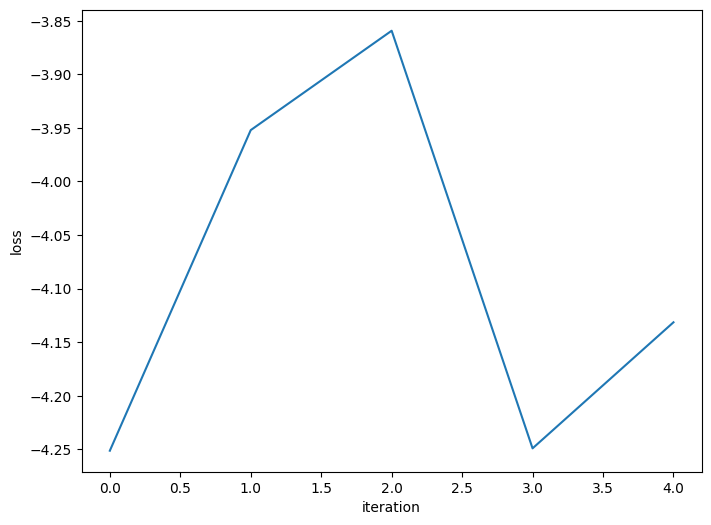

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -816.22797  validloss -736.21622±0.00000  bestvalidloss -736.21622  last_update 0
train: iter 1  trainloss -814.28603  validloss -738.51198±0.00000  bestvalidloss -738.51198  last_update 0
train: iter 2  trainloss -826.50347  validloss -751.75397±0.00000  bestvalidloss -751.75397  last_update 0
train: iter 3  trainloss -803.48065  validloss -751.19927±0.00000  bestvalidloss -751.75397  last_update 1
train: iter 4  trainloss -818.47143  validloss -733.98627±0.00000  bestvalidloss -751.75397  last_update 2
train: iter 5  trainloss -823.68160  validloss -734.13055±0.00000  bestvalidloss -751.75397  last_update 3
train: iter 6  trainloss -826.10457  validloss -737.57111±0.00000  bestvalidloss -751.75397  last_update 4
train: iter 7  trainloss -786.37374  validloss -725.43956±0.00000  bestvalidloss -751.75397  last_update 5
train: iter 8  trainloss -810.41793  validloss -743.63088±0.00000  bestvalidloss -751.75397  last_u

train: iter 76  trainloss -793.78536  validloss -725.43770±0.00000  bestvalidloss -755.43209  last_update 51
train: iter 77  trainloss -817.16230  validloss -732.38121±0.00000  bestvalidloss -755.43209  last_update 52
train: iter 78  trainloss -810.91427  validloss -746.85472±0.00000  bestvalidloss -755.43209  last_update 53
train: iter 79  trainloss -809.86819  validloss -721.62030±0.00000  bestvalidloss -755.43209  last_update 54
train: iter 80  trainloss -807.10905  validloss -738.10479±0.00000  bestvalidloss -755.43209  last_update 55
train: iter 81  trainloss -825.13578  validloss -745.39593±0.00000  bestvalidloss -755.43209  last_update 56
train: iter 82  trainloss -812.11278  validloss -743.03720±0.00000  bestvalidloss -755.43209  last_update 57
train: iter 83  trainloss -824.51028  validloss -746.54615±0.00000  bestvalidloss -755.43209  last_update 58
train: iter 84  trainloss -806.68397  validloss -725.22106±0.00000  bestvalidloss -755.43209  last_update 59
train: iter 85  tra

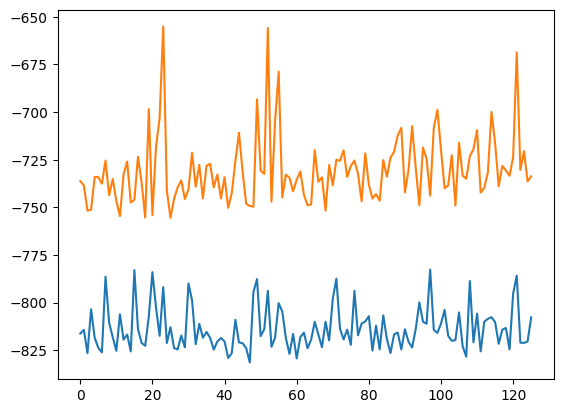

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-30 09:04:55.604518


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.33477  validloss 0.34907±0.00000  bestvalidloss 0.34907  last_update 0
train: iter 1  trainloss 0.32308  validloss 0.29248±0.00000  bestvalidloss 0.29248  last_update 0
train: iter 2  trainloss 0.32111  validloss 0.28877±0.00000  bestvalidloss 0.28877  last_update 0
train: iter 3  trainloss 0.31650  validloss 0.28362±0.00000  bestvalidloss 0.28362  last_update 0
train: iter 4  trainloss 0.31508  validloss 0.29047±0.00000  bestvalidloss 0.28362  last_update 1
train: iter 5  trainloss 0.31234  validloss 0.27942±0.00000  bestvalidloss 0.27942  last_update 0
train: iter 6  trainloss 0.31082  validloss 0.27841±0.00000  bestvalidloss 0.27841  last_update 0
train: iter 7  trainloss 0.30957  validloss 0.28882±0.00000  bestvalidloss 0.27841  last_update 1
train: iter 8  trainloss 0.30670  validloss 0.28419±0.00000  bestvalidloss 0.27841  last_update 2
train: iter 9  trainloss 0.30788  validloss 0.28387±0.00000  bestvalidloss 0.27841  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.27789  validloss 0.29286±0.00000  bestvalidloss 0.27702  last_update 69
train: iter 84  trainloss 0.27999  validloss 0.28623±0.00000  bestvalidloss 0.27702  last_update 70
train: iter 85  trainloss 0.28084  validloss 0.28985±0.00000  bestvalidloss 0.27702  last_update 71
train: iter 86  trainloss 0.28211  validloss 0.28459±0.00000  bestvalidloss 0.27702  last_update 72
train: iter 87  trainloss 0.27853  validloss 0.29190±0.00000  bestvalidloss 0.27702  last_update 73
train: iter 88  trainloss 0.27947  validloss 0.28914±0.00000  bestvalidloss 0.27702  last_update 74
train: iter 89  trainloss 0.28018  validloss 0.29583±0.00000  bestvalidloss 0.27702  last_update 75
train: iter 90  trainloss 0.27919  validloss 0.29025±0.00000  bestvalidloss 0.27702  last_update 76
train: iter 91  trainloss 0.27901  validloss 0.29679±0.00000  bestvalidloss 0.27702  last_update 77
train: iter 92  trainloss 0.27904  validloss 0.29134±0.00000  bestvalidloss 0.27702  last_update 78


([0.3347665101289749,
  0.3230813590809703,
  0.32110889730975034,
  0.3165029490366578,
  0.3150802129879594,
  0.3123373622074723,
  0.310824819188565,
  0.30956548573449255,
  0.3066973388195038,
  0.3078780663199723,
  0.3075285811908543,
  0.30655246376991274,
  0.30157170761376617,
  0.3019721072167158,
  0.30076706809923054,
  0.30088259363546965,
  0.30129975024610756,
  0.30063163517042996,
  0.2975808596238494,
  0.30053284084424375,
  0.29777701636776327,
  0.2959296808578074,
  0.2978215293027461,
  0.3002325692214072,
  0.29607257852330804,
  0.2925611278042197,
  0.29293572092428805,
  0.2932052751071751,
  0.2931459563784301,
  0.29249960351735355,
  0.291306487377733,
  0.29340941114351154,
  0.2920285064727068,
  0.2919062715023756,
  0.29456677082926036,
  0.2909611154347658,
  0.29055212112143636,
  0.29084120951592923,
  0.2897963345050812,
  0.28785999175161125,
  0.2909018412232399,
  0.28845636900514365,
  0.2913589335978031,
  0.2938731834292412,
  0.29021148588

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.467463269078732
valid_loss:  -4.114221052122117
weight_alpha 1.0 h_min_tilde -11.744873 ell_tilde -3.596814825687409 kappa_tilde 0.0003503264580653527
train_loss:  -3.981352993154526
valid_loss:  -3.507644512653351
weight_alpha 0.1 h_min_tilde -11.744873 ell_tilde -3.886611297054291 kappa_tilde 0.0003567276350962425


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 43.94462  validloss 48.48314±0.00000  bestvalidloss 48.48314  last_update 0
train: iter 1  trainloss 30.91830  validloss 32.57135±0.00000  bestvalidloss 32.57135  last_update 0
train: iter 2  trainloss 21.43110  validloss 21.91849±0.00000  bestvalidloss 21.91849  last_update 0
train: iter 3  trainloss 14.49720  validloss 14.64750±0.00000  bestvalidloss 14.64750  last_update 0
train: iter 4  trainloss 9.99125  validloss 9.06058±0.00000  bestvalidloss 9.06058  last_update 0
train: iter 5  trainloss 6.55178  validloss 5.69093±0.00000  bestvalidloss 5.69093  last_update 0
train: iter 6  trainloss 4.27273  validloss 3.37379±0.00000  bestvalidloss 3.37379  last_update 0
train: iter 7  trainloss 2.61529  validloss 1.71452±0.00000  bestvalidloss 1.71452  last_update 0
train: iter 8  trainloss 1.31593  validloss 0.60724±0.00000  bestvalidloss 0.60724  last_update 0
train: iter 9  trainloss 0.61157  validloss -0.34376±0.00000  bestvalidloss -0.34376  last_update 0
train:

train: iter 94  trainloss -1.18375  validloss -1.56411±0.00000  bestvalidloss -1.64676  last_update 79
train: iter 95  trainloss -1.19852  validloss -1.58089±0.00000  bestvalidloss -1.64676  last_update 80
train: iter 96  trainloss -1.19841  validloss -1.57934±0.00000  bestvalidloss -1.64676  last_update 81
train: iter 97  trainloss -1.11918  validloss -1.55697±0.00000  bestvalidloss -1.64676  last_update 82
train: iter 98  trainloss -1.10907  validloss -1.56641±0.00000  bestvalidloss -1.64676  last_update 83
train: iter 99  trainloss -1.21051  validloss -1.48296±0.00000  bestvalidloss -1.64676  last_update 84
train: iter 100  trainloss -1.21460  validloss -1.48365±0.00000  bestvalidloss -1.64676  last_update 85
train: iter 101  trainloss -1.11217  validloss -1.51883±0.00000  bestvalidloss -1.64676  last_update 86
train: iter 102  trainloss -1.15468  validloss -1.54709±0.00000  bestvalidloss -1.64676  last_update 87
train: iter 103  trainloss -1.17455  validloss -1.55237±0.00000  bestv

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-2.2600, -1.3835, -5.3577, -3.8730], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 4.20349  validloss 11.95565±0.00000  bestvalidloss 11.95565  last_update 0
train: iter 1  trainloss 4.10201  validloss 13.45356±0.00000  bestvalidloss 11.95565  last_update 1
train: iter 2  trainloss 4.07211  validloss 13.46326±0.00000  bestvalidloss 11.95565  last_update 2
train: iter 3  trainloss 4.01453  validloss 13.28125±0.00000  bestvalidloss 11.95565  last_update 3
train: iter 4  trainloss 3.99790  validloss 12.93755±0.00000  bestvalidloss 11.95565  last_update 4
train: iter 5  trainloss 4.01139  validloss 13.11754±0.00000  bestvalidloss 11.95565  last_update 5
train: iter 6  trainloss 4.02256  validloss 13.62394±0.00000  bestvalidloss 11.95565  last_update 6
train: iter 7  trainloss 4.02972  validloss 12.88961±0.00000  bestvalidloss 11.95565  last_update 7
train: iter 8  trainloss 4.04463  validloss 13.31618±0.00000  bestvalidloss 11.95565  last_update 8
train: iter 9  trainloss 3.96066  validloss 12.73910±0.00000  bestvalidloss 11.95565  last_update 9


train: iter 81  trainloss 3.90761  validloss 13.85557±0.00000  bestvalidloss 11.95565  last_update 81
train: iter 82  trainloss 3.87574  validloss 12.64472±0.00000  bestvalidloss 11.95565  last_update 82
train: iter 83  trainloss 3.90717  validloss 13.03662±0.00000  bestvalidloss 11.95565  last_update 83
train: iter 84  trainloss 3.90472  validloss 13.07390±0.00000  bestvalidloss 11.95565  last_update 84
train: iter 85  trainloss 3.88779  validloss 13.41403±0.00000  bestvalidloss 11.95565  last_update 85
train: iter 86  trainloss 3.92133  validloss 12.59465±0.00000  bestvalidloss 11.95565  last_update 86
train: iter 87  trainloss 3.94665  validloss 12.54494±0.00000  bestvalidloss 11.95565  last_update 87
train: iter 88  trainloss 3.96868  validloss 12.29097±0.00000  bestvalidloss 11.95565  last_update 88
train: iter 89  trainloss 3.98389  validloss 13.01355±0.00000  bestvalidloss 11.95565  last_update 89
train: iter 90  trainloss 3.98076  validloss 12.50613±0.00000  bestvalidloss 11.95

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-12.8742)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(8.0305)


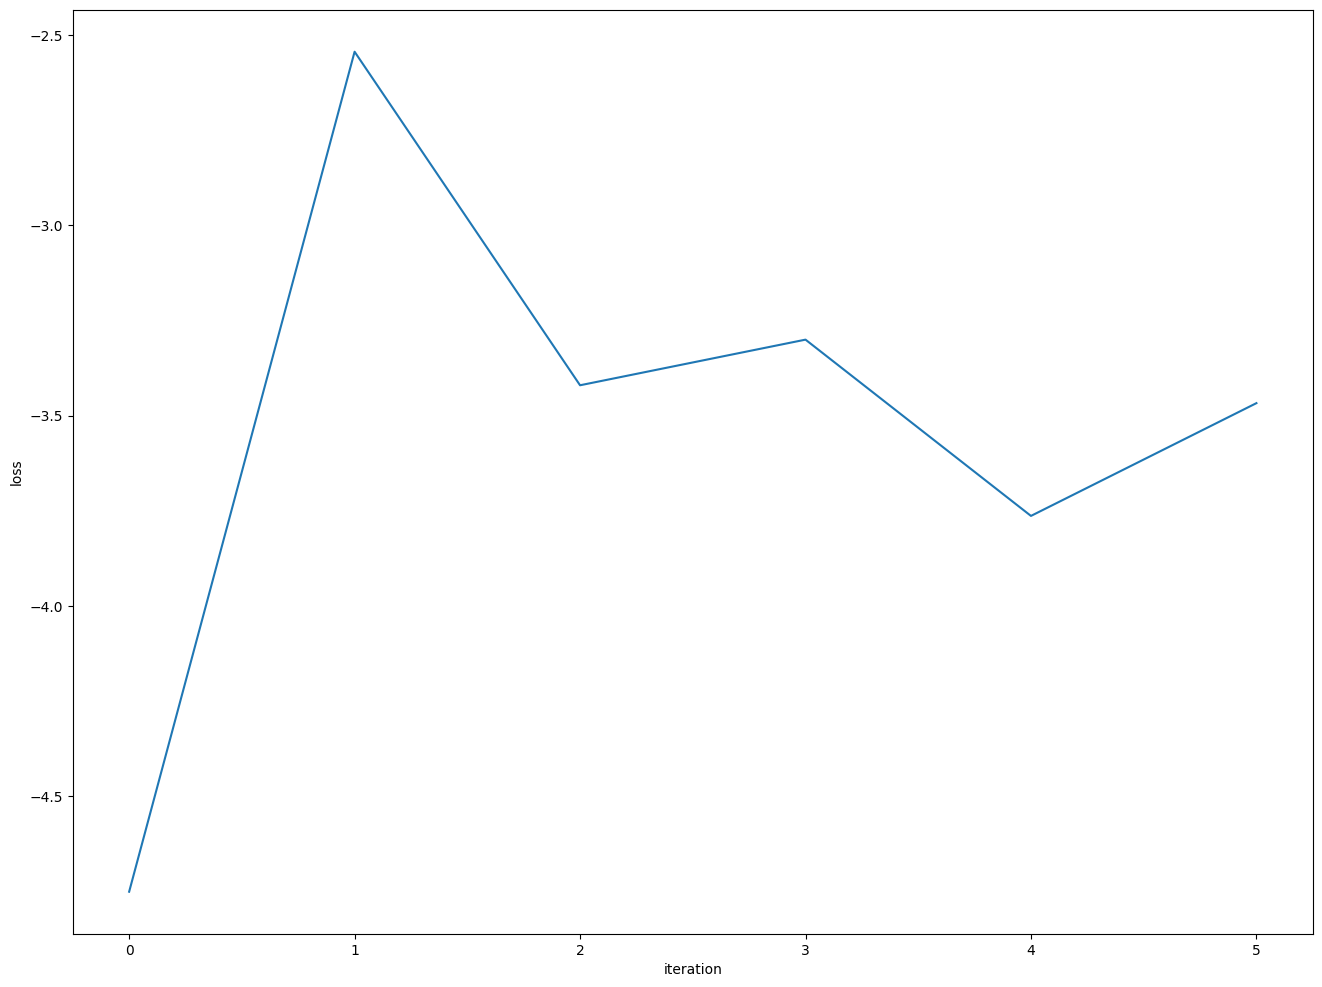

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

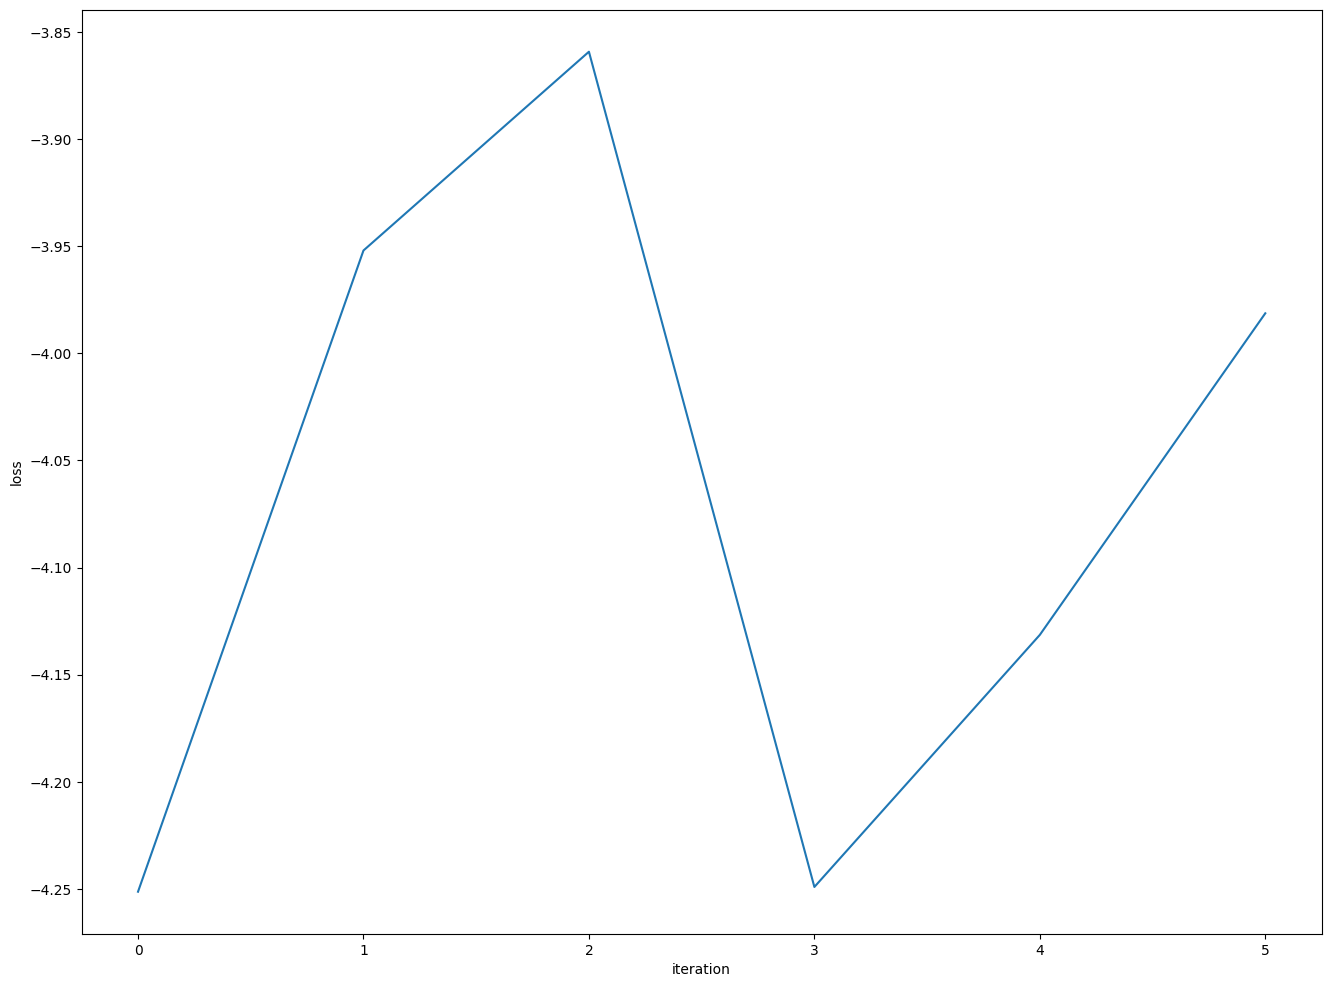

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")